In [54]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



In [55]:
# Load data
data = pd.read_csv('NVDA.csv')
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400


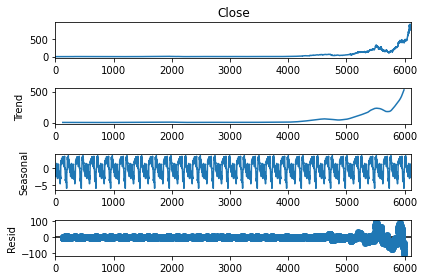

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the Close price time series
decomposition = seasonal_decompose(data['Close'], model='additive', period=252)  # Assuming daily data, 252 days in a year

# Plot decomposition
decomposition.plot()
plt.show()

<ipython-input-57-128c7a5f9a84>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_six_months['MA20'] = last_six_months['Close'].rolling(window=20).mean()


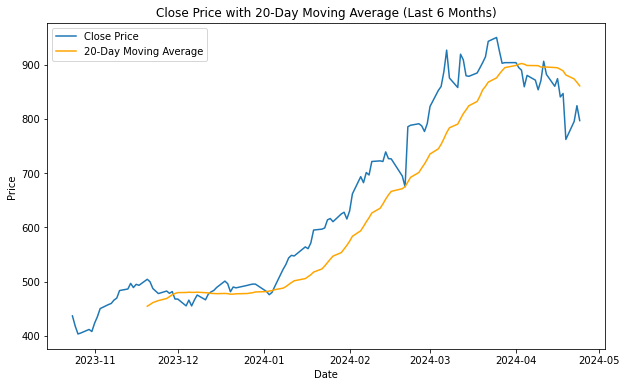

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Date' is in datetime format, otherwise convert it first
data['Date'] = pd.to_datetime(data['Date'])

# Filter data for the last 6 months
last_six_months = data[data['Date'] >= (data['Date'].max() - pd.DateOffset(months=6))]

# Calculate the 20-day moving average only for the filtered data
last_six_months['MA20'] = last_six_months['Close'].rolling(window=20).mean()

# Plot Close price with the 20-day moving average for the last six months
plt.figure(figsize=(10, 6))
plt.plot(last_six_months['Date'], last_six_months['Close'], label='Close Price')
plt.plot(last_six_months['Date'], last_six_months['MA20'], label='20-Day Moving Average', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price with 20-Day Moving Average (Last 6 Months)')
plt.legend()
plt.show()


In [58]:
# Extract OHLC data
ohlc_data = data[['Open', 'High', 'Low', 'Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
ohlc_scaled = scaler.fit_transform(ohlc_data)

In [59]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        label = data[i + seq_length, -1]  # Assuming we are still predicting the 'Close' price
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 60  # Or any other number of time steps
X, y = create_sequences(ohlc_scaled, seq_length)


In [60]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out[:, -1])  # Only take the last time step's output
        return predictions

# Define model parameters
input_size = 4  # Because we are only feeding in one feature (price)
hidden_layer_size = 100  # Number of LSTM cells
output_size = 1  # Predicting a single value (next price)

# Initialize the model
model = LSTMModel(input_size, hidden_layer_size, output_size)


In [62]:
# Convert data to PyTorch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Reshape y_tensor to have the right shape for training
y_tensor = y_tensor.unsqueeze(1)  # Adding an extra dimension for batch size


In [63]:
# Number of epochs
num_epochs = 20 # You can increase or decrease this based on training time and performance

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Reset hidden state
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))
    
    # Forward pass: predict based on the input
    y_pred = model(X_tensor)
    
    # Calculate the loss
    loss = loss_function(y_pred, y_tensor)
    
    # Backward pass: calculate gradients
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    # Print the loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


RuntimeError: Expected hidden[0] size (1, 6056, 100), got [1, 1, 100]

In [65]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load your dataset
data = pd.read_csv('NVDA.csv')

# Select relevant features (Open, High, Low, Close)
features = data[['Open', 'High', 'Low', 'Close']].values

# Normalize the data (feature scaling)
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)

# Create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        label = data[i + seq_length, 3]  # Use Close price as the target
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Set sequence length (e.g., using past 60 time steps)
seq_length = 60
X, y = create_sequences(features_scaled, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out[:, -1])  # Only take the last output
        return predictions

# Initialize model
input_size = 4  # Number of features (Open, High, Low, Close)
hidden_layer_size = 100
output_size = 1  # Predicting the next Close price
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Define loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 20
for epoch in range(epochs):
    model.train()
    for i in range(len(X)):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(X[i].unsqueeze(0))  # Unsqueeze to add batch dimension
        single_loss = loss_function(y_pred, y[i].unsqueeze(0))
        single_loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {single_loss.item()}')

# Make predictions
model.eval()
with torch.no_grad():
    predictions = []
    for i in range(len(X)):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(X[i].unsqueeze(0)).item())

# Invert scaling to get actual prices
predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(np.hstack((np.zeros_like(predictions), np.zeros_like(predictions), np.zeros_like(predictions), predictions)))[:, 3]

# Plot actual vs predicted Close prices
actual_close = data['Close'].values[seq_length:]  # True Close prices
plt.plot(actual_close, label='Actual Close')
plt.plot(predictions, label='Predicted Close')
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_close, predictions))
print(f'RMSE: {rmse}')


c:\Users\alina\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.00028437646687962115


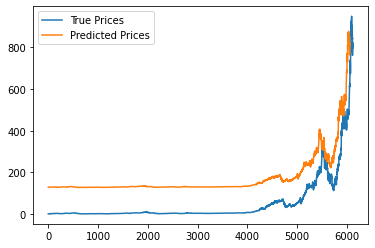

In [14]:
# Make predictions on the same data (for evaluation)
model.eval()
with torch.no_grad():
    predictions = []
    for i in range(len(X)):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        predictions.append(model(X[i].unsqueeze(0)).item())

# Invert scaling to get actual prices
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot the results
plt.plot(prices, label='True Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(prices[seq_length:], predictions))
print(f'RMSE: {rmse}')

RMSE: 120.67565101120071
